In [1]:
from google.colab import files
upload = files.upload()

Saving problem_instance3.txt to problem_instance3.txt
Saving problem_instance2.txt to problem_instance2.txt
Saving problem_instance1.txt to problem_instance1.txt


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt  # Importing matplotlib for plots

# Step 1: Parse Problem Data
def parse_problem(file_path):
    with open(file_path, 'r') as file:
        lines = [line.strip() for line in file.readlines()]  # Remove extra spaces and line breaks

    # Parse number of agents and jobs
    agents_jobs = lines[0].split(", ")
    num_agents = int(agents_jobs[0].split()[0])
    num_jobs = int(agents_jobs[1].split()[0])

    # Parse costs
    cost_start_idx = lines.index("cost of allocating job j to agent i") + 1
    cost_end_idx = cost_start_idx + num_agents
    costs = [list(map(int, line.split())) for line in lines[cost_start_idx:cost_end_idx]]

    # Parse resource consumption
    resource_start_idx = lines.index("resource consumed in allocating job j to agent i") + 1
    resource_end_idx = resource_start_idx + num_agents
    resource_consumptions = [list(map(int, line.split())) for line in lines[resource_start_idx:resource_end_idx]]

    # Parse resource capacities
    capacity_idx = lines.index("resource capacity of agent i") + 1
    resource_capacities = list(map(int, lines[capacity_idx].split()))

    return num_agents, num_jobs, np.array(costs), np.array(resource_consumptions), np.array(resource_capacities)


In [6]:
# Step 2: Initialize Solution
def initialize_solution(num_agents, num_jobs, resource_consumptions, resource_capacities):
    solution = []
    resources_used = [0] * num_agents
    for j in range(num_jobs):
        min_overload = float('inf')
        selected_agent = None
        for i in range(num_agents):
            projected_usage = resources_used[i] + resource_consumptions[i][j]
            overload = projected_usage - resource_capacities[i]
            if overload < min_overload:
                min_overload = overload
                selected_agent = i
        if selected_agent is not None:
            solution.append(selected_agent)
            resources_used[selected_agent] += resource_consumptions[selected_agent][j]
        else:
            # Assign to the agent with the most remaining capacity
            max_capacity = max(resource_capacities)
            selected_agent = resource_capacities.index(max_capacity)
            solution.append(selected_agent)
            resources_used[selected_agent] += resource_consumptions[selected_agent][j]
    return solution, resources_used

Terminating search after 68 iterations with no improvement.
Best Solution for problem-instances/problem_instance1.txt:
[2, 3, 0, 0, 4, 1, 2, 3, 4, 3, 0, 1, 1, 1, 4, 0, 1, 2, 2, 3, 3, 0, 2, 4, 1]
Best Cost for problem-instances/problem_instance1.txt: 450
Terminating search after 79 iterations with no improvement.
Best Solution for problem-instances/problem_instance2.txt:
[3, 4, 2, 2, 0, 7, 5, 3, 1, 6, 6, 4, 2, 0, 7, 0, 7, 3, 5, 1, 4, 3, 5, 2, 3, 6, 3, 0, 7, 1, 1, 6, 6, 0, 6, 7, 0, 6, 2, 6]
Best Cost for problem-instances/problem_instance2.txt: 673
Terminating search after 118 iterations with no improvement.
Best Solution for problem-instances/problem_instance3.txt:
[1, 3, 3, 4, 5, 3, 5, 9, 2, 7, 4, 4, 2, 4, 4, 2, 1, 9, 1, 1, 2, 7, 2, 0, 0, 4, 1, 1, 0, 6, 4, 5, 9, 6, 8, 2, 7, 3, 0, 8, 8, 9, 5, 9, 6, 3, 6, 9, 5, 7]
Best Cost for problem-instances/problem_instance3.txt: 594


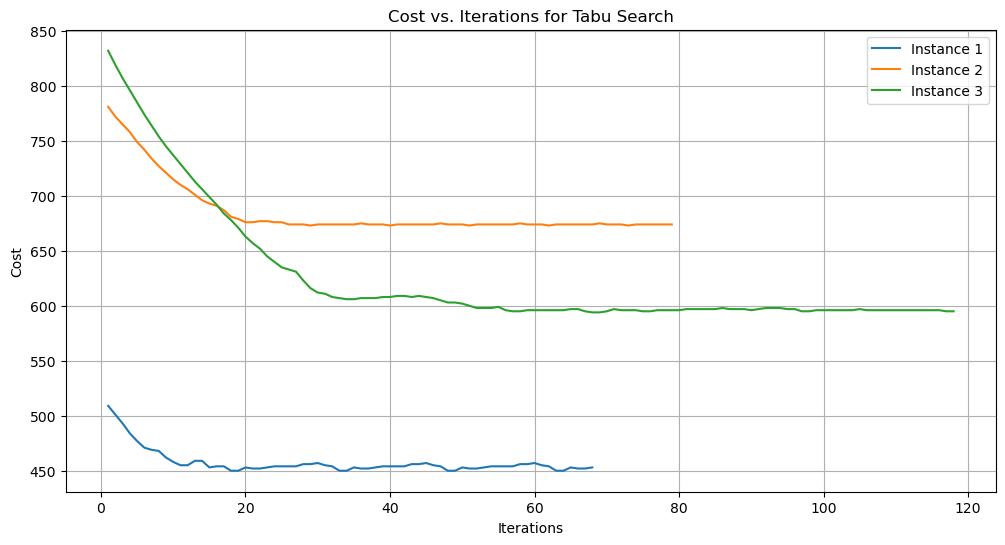

In [9]:
# Step 3: Calculate Total Cost (Penalty if capacity violation)
def calculate_cost(solution, costs, resource_consumptions, resource_capacities):
    total_cost = 0
    resources_used = [0] * len(resource_capacities)
    for j, agent in enumerate(solution):
        total_cost += costs[agent][j]
        resources_used[agent] += resource_consumptions[agent][j]
    # Add penalty for capacity violations
    penalty = 0
    for i in range(len(resource_capacities)):
        if resources_used[i] > resource_capacities[i]:
            penalty += (resources_used[i] - resource_capacities[i]) * 1000  # Penalty coefficient
    total_cost += penalty
    return total_cost

# Step 4: Check Feasibility of a Solution
# Function to check feasibility
def is_feasible(solution, resource_consumptions, resource_capacities):
    num_agents = len(resource_capacities)
    resources_used = [0] * num_agents
    for j, agent in enumerate(solution):
        resources_used[agent] += resource_consumptions[agent][j]
    for i in range(num_agents):
        if resources_used[i] > resource_capacities[i]:
            return False
    return True

# Step 5: Generate Neighboring Solutions
def get_neighbors(solution, num_agents, resource_consumptions, resource_capacities):
    neighbors = []
    num_jobs = len(solution)
    for j in range(num_jobs):
        current_agent = solution[j]
        for i in range(num_agents):
            if i != current_agent:
                new_solution = solution.copy()
                new_solution[j] = i
                if is_feasible(new_solution, resource_consumptions, resource_capacities):
                    neighbors.append(new_solution)
    return neighbors

# Step 6: Tabu Search Algorithm (Tabu override implemented)
def tabu_search(num_agents, num_jobs, costs, resource_consumptions, resource_capacities, max_iterations, tabu_tenure, no_improvement_limit):
    solution, resources_used = initialize_solution(num_agents, num_jobs, resource_consumptions, resource_capacities)
    best_solution = solution
    best_cost = calculate_cost(solution, costs, resource_consumptions, resource_capacities)
    tabu_list = []
    cost_history = []
    no_improvement_counter = 0

    for iteration in range(max_iterations):
        neighbors = get_neighbors(solution, num_agents, resource_consumptions, resource_capacities)
        best_neighbor = None
        best_neighbor_cost = float('inf')
        # aspiration tabu override
        for neighbor in neighbors:
            neighbor_cost = calculate_cost(neighbor, costs, resource_consumptions, resource_capacities)
            if neighbor in tabu_list and neighbor_cost >= best_cost:
                continue
            if neighbor_cost < best_neighbor_cost:
                best_neighbor = neighbor
                best_neighbor_cost = neighbor_cost

        if best_neighbor is None:
            break

        solution = best_neighbor
        cost_history.append(best_neighbor_cost)

        # Update tabu list
        tabu_list.append(solution)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

        # Check for improvement
        if best_neighbor_cost < best_cost:
            best_cost = best_neighbor_cost
            best_solution = best_neighbor
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            if no_improvement_counter >= no_improvement_limit:
                print(f"Terminating search after {iteration+1} iterations with no improvement.")
                break


    return best_solution, best_cost, cost_history

# Step 7: Main Execution
file_path_1 = r"problem-instances/problem_instance1.txt"
file_path_2 = r"problem-instances/problem_instance2.txt"
file_path_3 = r"problem-instances/problem_instance3.txt"

file_paths = [file_path_1, file_path_2, file_path_3]
plot_data = []  # To store data for plotting

for file_path in file_paths:
    num_agents, num_jobs, costs, resource_consumptions, resource_capacities = parse_problem(file_path)

    # Parameters
    max_iterations = 1000  # Maximum iterations as a safety net
    tabu_tenure = 10
    no_improvement_limit = 50  # Terminate after 50 iterations without improvement

    # Run the tabu search algorithm
    best_solution, best_cost, cost_history = tabu_search(
        num_agents,
        num_jobs,
        costs,
        resource_consumptions,
        resource_capacities,
        max_iterations,
        tabu_tenure,
        no_improvement_limit
    )

    print(f"Best Solution for {file_path}:")
    print(best_solution)
    print(f"Best Cost for {file_path}: {best_cost}")

    plot_data.append((file_path, cost_history))  # Collect data for plotting

# Step 8: Plot Results
plt.figure(figsize=(12, 6))

for i, (file_path, cost_history) in enumerate(plot_data):
    plt.plot(range(1, len(cost_history) + 1), cost_history, label=f"Instance {i+1}")

plt.title("Cost vs. Iterations for Tabu Search")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.show()
